In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import xarray as xr
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import cmath 

In [26]:
### MOSAiC Summer School
# Code by Thomas Rackow (AWI, YOPP) for 'climatological' sea ice buoy forecasts.
# We will try to extend it to a real forecast by using whatever U,V near-realtime forecasts will 
# be available on the Akademik Fedorov.
# (c) 2019

In [27]:
# based on...
# 1) Low Resolution Sea Ice Drift from
# ftp://osisaf.met.no/archive/ice/drift_lr/

In [28]:
# and 2) AMSR-2 Global Sea Ice Concentration
# ftp://osisaf.met.no/prod/ice/conc_amsr/

## download the data from share folder / USB stick: sea ice drift velocities

### download latest drift velocities into folder 'drift-velocities'
! wget -nv --mirror --no-host-directories --user=anonymous --password=anonymous -P /home/htweedie/melt_ponds/data/drift-velocities ftp://osisaf.met.no/archive/ice/drift_lr/merged/

### download sea ice concentration into folder 'seaice-concentration'
! wget -nv --mirror --no-host-directories --user=anonymous --password=anonymous -P /home/htweedie/melt_ponds/data/seaice-concentration ftp://osisaf.met.no/prod/ice/conc_amsr/

##### an example file

In [6]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc


In [8]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/


2009  2011  2013  2015	2017  2019  2021  2023
2010  2012  2014  2016	2018  2020  2022  2024


### look at the data

In [9]:
!ncdump -h /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

netcdf ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200 {
dimensions:
	time = 1 ;
	nv = 2 ;
	xc = 119 ;
	yc = 177 ;
variables:
	int Polar_Stereographic_Grid ;
		Polar_Stereographic_Grid:grid_mapping_name = "polar_stereographic" ;
		Polar_Stereographic_Grid:straight_vertical_longitude_from_pole = -45.f ;
		Polar_Stereographic_Grid:latitude_of_projection_origin = 90.f ;
		Polar_Stereographic_Grid:standard_parallel = 70.f ;
		Polar_Stereographic_Grid:false_easting = 0.f ;
		Polar_Stereographic_Grid:false_northing = 0.f ;
		Polar_Stereographic_Grid:semi_major_axis = 6378273.f ;
		Polar_Stereographic_Grid:semi_minor_axis = 6356890.f ;
		Polar_Stereographic_Grid:proj4_string = "+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45" ;
	double time(time) ;
		time:axis = "T" ;
		time:long_name = "reference time of product" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1978-01-01 00:00:00" ;
		time:calendar = "standard" ;
		time:bounds = "time_bnds

In [10]:
! ls /Users/micheltsamados/Google\ Drive/ADMINISTRATION/MosaicNERC2018/FieldTrip/WORK/DriftRackow/2017/09/

ls: cannot access /Users/micheltsamados/Google Drive/ADMINISTRATION/MosaicNERC2018/FieldTrip/WORK/DriftRackow/2017/09/: No such file or directory


In [17]:
# load the example file
#OSISAFfile = '/Users/micheltsamados/Google Drive/ADMINISTRATION/MosaicNERC2018/FieldTrip/WORK/DriftRackow/drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201708301200-201709011200.nc'
OSISAFfile = '/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc'
fl = Dataset(OSISAFfile)
#xc=fl.variables['xc']
#yc=fl.variables['yc']
#XC,YC=np.meshgrid(xc,yc)

# lon lat on grid
lon_start=np.copy(fl.variables['lon'])
lat_start=np.copy(fl.variables['lat'])

# lon lat at the end of the displacement
lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
lat_end=np.squeeze(fl.variables['lat1'][0,:,:])

# max and min start and end coords
lon_end.min(), lon_end.max(), lon_start.min(), lon_start.max()

(-179.70926, 179.05727, -180.0, 179.52649)

In [9]:
# a useful function we'll need

r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km

In [18]:
# Construct U,V sea ice velocity here for plotting
# calculate magnitude of velocities and store as plotfield
deltalon = lon_end-lon_start
deltalon[deltalon>100.] = deltalon[deltalon>100.]-360. # jump at -180..180
deltalon[deltalon<-100.] = deltalon[deltalon<-100.]+360. # jump at -180..180
Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. * 3.6 # km/h -> m/s
Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. * 3.6 #km/h -> m/s
plotfield=np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s
#plotfield=Ufield

/tmp/ipykernel_121106/1646763335.py:8: RuntimeWarning: invalid value encountered in sqrt
  plotfield=np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s


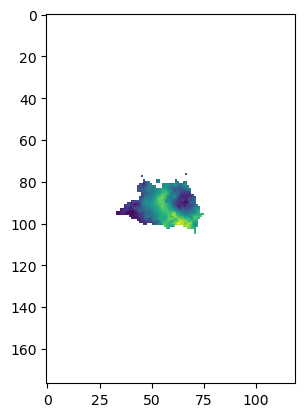

In [19]:
# this is the 
np.size(plotfield)
plt.imshow(plotfield)
plt.show()

#### Where is that supposed to be..?! Add geographic information with Basemap

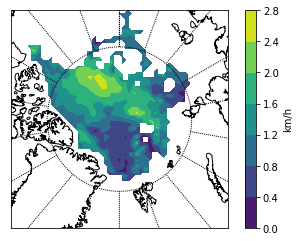

In [70]:
m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l')
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
im=m.contourf(lon_map,lat_map,plotfield)

cbar=plt.colorbar()
cbar.set_label('km/h')

plt.show()

### Better! So let's compute forward buoy trajectories with the following code (class Buoys)

In [4]:
class Buoys:
    
    global rad, r_earth
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date):
        self.oldlon = lon_start*rad
        self.oldlat = lat_start*rad
        self.lon = lon_start*rad
        self.lat = lat_start*rad
        self.initlon = lon_start*rad
        self.initlat = lat_start*rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        #self.delta_x = np.zeros(lon_start.shape)
        #self.delta_y = np.zeros(lon_start.shape)
        #self.u_ice = np.zeros(lon_start.shape)
        #self.v_ice = np.zeros(lon_start.shape)
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u,new_v, delta_t):
        print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg=self.lon/rad % 360
        lat_deg=np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        #idx=getindices_beforestart(self.getdate(), self.startdates)
        #lon_deg[idx] = np.nan
        #lat_deg[idx] = np.nan
        #self.lon[idx] = self.initlon[idx]
        #self.lat[idx] = self.initlat[idx]
        #self.old_u[idx]=0.
        #self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg


In [5]:
# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(startdates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices

In [6]:
# load OSISAF data for Northern Hemisphere at a certain date
def loaddate_ofOSISAF(datestring, hemisphere='nh'):
    
    # convert datestring to datetime object
    thedate = datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S")
    
    # let's construct the file name, 
    # e.g. drift-velocities/archive/ice/drift_lr/merged/2019/09/
    # ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
    pathtofile="/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/"
    # middle part
    middlefilename="ice_drift_"+hemisphere+"_polstere-625_multi-oi_"
    # e.g. 201907291200-201907311200 (48hr span)
    enddate=thedate + timedelta(days=2)
    # YYYY/MM/ (from end date)
    YYYYMM=enddate.strftime("%Y")+"/"+enddate.strftime("%m")+"/"
    endfilename= thedate.strftime("%Y%m%d%H%M") + "-" + enddate.strftime("%Y%m%d%H%M") + '.nc'
    
    # the OSISAF file to be loaded
    filename=pathtofile + YYYYMM + middlefilename + endfilename
    
    # take previous files in case there is a data gap
    sd=thedate
    ed=enddate
    while os.path.isfile(filename)!=True:
        # try previous file
        sd=sd - timedelta(days=1)
        ed=ed - timedelta(days=1)
        # YYYY/MM/ (from end date)
        YYYYMM=ed.strftime("%Y")+"/"+ed.strftime("%m")+"/"
        endfilename= sd.strftime("%Y%m%d%H%M") + "-" + ed.strftime("%Y%m%d%H%M") + '.nc'
        filename=pathtofile + YYYYMM + middlefilename + endfilename
        print('data gap: try previous file '+filename+' ...')
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    #xc=fl.variables['xc']
    #yc=fl.variables['yc']
    #XC,YC=np.meshgrid(xc,yc)
    
    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])

    # lon lat at the end of the displacement
    lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
    lat_end=np.squeeze(fl.variables['lat1'][0,:,:])
    
    # close the file
    fl.close()
    
    # compute Ufield from end points and start points (48hour change)
    deltalon=lon_end-lon_start
    deltalon[deltalon>100.]=deltalon[deltalon>100.]-360.   # jump at -180..180
    deltalon[deltalon<-100.]=deltalon[deltalon<-100.]+360. # jump at -180..180
    Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. / 3.6 # km/h -> m/s
    
    # compute Vfield as well
    Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. / 3.6 #km/h -> m/s
    
    return Ufield, Vfield

In [10]:
# test the function (sometimes there are data gaps that need to be handled)
datestring='2013-03-22 12:00:00'
Ufield, Vfield = loaddate_ofOSISAF(datestring, hemisphere='nh')

data gap: try previous file /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2013/03/ice_drift_nh_polstere-625_multi-oi_201303211200-201303231200.nc ...
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2013/03/ice_drift_nh_polstere-625_multi-oi_201303211200-201303231200.nc ...


In [11]:
# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(lon_start,lat_start, Ufield,Vfield, objects):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    lon_adjust=objects.lon/rad
    lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust,objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx=spatial.KDTree(A).query(tuples)[1]
    
    return Ufield[idx], Vfield[idx]

In [12]:
def find_idx_atbuoy_pos(lon_start,lat_start, poslon, poslat):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; poslon is 0..360
    lon_adjust=poslon
    lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust,poslat)) 
    
    # fast KDTree nearest neighbor method
    return spatial.KDTree(A).query(tuples)[1]

### Generate DataFrame of buoy positions and dates

In [43]:
# get the SIDFEx buoy information ("targets")
# updated once per hour, every day, 24/7
!wget https://swift.dkrz.de/v1/dkrz_0262ea1f00e34439850f3f1d71817205/SIDFEx_index/SIDFEx_targettable.txt

--2019-10-01 10:21:13--  https://swift.dkrz.de/v1/dkrz_0262ea1f00e34439850f3f1d71817205/SIDFEx_index/SIDFEx_targettable.txt
Resolving swift.dkrz.de (swift.dkrz.de)... 136.172.36.74, 136.172.36.73, 136.172.36.75
Connecting to swift.dkrz.de (swift.dkrz.de)|136.172.36.74|:443... connected.
Unable to establish SSL connection.


In [53]:
less SIDFEx_targettable.txt

In [54]:
# skip header (20 rows), read first two columns separately as strings
fname='SIDFEx_targettable.txt'
#0:TargetID 
#1:Current_Target 
targets_ID=np.loadtxt(fname, skiprows=20, usecols=(0,1), dtype='str') #'string'
#2:Latest_Position_Year 0
#3:Latest_Position_DayOfYear 1
#4:Latest_Position_Lat 2
#5:Latest_Position_Lon 3
#6:Total_First_Year 4
#7:Total_First_DayOfYear 5
#8:SIDFEx_First_Year 6
#9:SIDFEx_First_DayOfYear 7
#10:SIDFEx_Last_Year 8
#11:SIDFEx_Last_DayOfYear 9
#12:Total_Last_Year 10
#13:Total_Last_DayOfYear 11
targets=np.loadtxt(fname, skiprows=20, usecols=(2,3,4,5,6,7,8,9,10,11,12,13))

In [46]:
SIDFEx_First_Year=np.array(targets[:,6],dtype='int')
SIDFEx_First_DayOfYear=targets[:,7]
start_dates=list()

In [47]:
for i,val in enumerate(SIDFEx_First_DayOfYear):
    dates=datetime.strptime(str(SIDFEx_First_Year[i])+"-01-01 00:00:00", "%Y-%m-%d %H:%M:%S") + timedelta(days=SIDFEx_First_DayOfYear[i]-1.)
    start_dates.append(dates.strftime("%Y-%m-%d %H:%M:%S"))
    
start_dates

['2017-01-01 00:00:00',
 '2017-01-01 00:00:00',
 '2017-01-01 00:00:00',
 '2017-01-01 00:00:00',
 '2017-06-18 00:00:00',
 '2017-01-01 01:59:31',
 '2017-01-01 00:00:00',
 '2017-01-01 00:00:00',
 '2017-01-01 21:00:00',
 '2018-03-29 20:29:45',
 '2018-03-30 19:01:55',
 '2018-06-02 22:59:31',
 '2018-06-16 06:00:00',
 '2018-06-15 15:00:00',
 '2018-06-15 15:00:00',
 '2018-06-15 15:00:00',
 '2018-04-22 04:00:28',
 '2018-11-13 21:00:00',
 '2018-10-17 00:00:00',
 '2018-10-17 00:00:00',
 '2018-10-17 00:00:00',
 '2019-07-29 00:00:00',
 '2019-07-29 00:00:00',
 '2019-07-29 00:00:00',
 '2019-07-29 00:00:00',
 '2019-07-29 00:00:00']

In [83]:
start_dates=[]
for i in range(10):
    start_dates.append('2018-09-03 00:00:00')
len(start_dates)
start_dates

['2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00',
 '2018-09-03 00:00:00']

In [14]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

poslat=np.array([83.5,84,84.5,85,85.5,86,86.5,87,87.5,88])#, \
                 #83.5,84,84.5,85,85.5,86,86.5,87,87.5,88, \
                 #83.5,84,84.5,85,85.5,86,86.5,87,87.5,88])
poslon=np.array([120,120,120,120,120,120,120,120,120,120])#, \
                 #125,125,125,125,125,125,125,125,125,125, \
                 #130,130,130,130,130,130,130,130,130,130])
#poslat=np.array([85.54045, 85.74480, 85.70138, 85.74371, 85.05740, 85.20440, 85.24860, 85.16620, \
#                 85.54620, 85.39185, 85.83907, 85.18900, 85.93260, 85.33100, 85.43820, 85.12240])#, \
#                 85.97849, 85.63360, 85.55300, 85.78700, 85.43040, 85., 85., 85., 85., 85.])
#poslon=np.array([125.44145, 125.71580, 125.48599, 125.74365, 125.96540, 125.20620, 125.38980, \
#                125.51140, 125.05740, 125.58145, 125.31197, 125.08760, 125.75800, 125.63920])#, \
#                125.96280, 125.60780, 125.82324, 125.91300, 125.54200, 125.48000, 125.44240, \
#                130., 120., 140., 120., 140.])
#poslat=np.array([72.54045, 73.74480, 73.70138, 75.74371, 69.05740, 80.20440, 79.24860, 84.16620, \
#                 74.54620, 72.39185, 71.83907, 84.18900, 80.93260, 86.33100, 81.43820, 84.12240, \
#                 89.97849, 78.63360, 82.55300, 83.78700, 83.43040, 85., 84., 84., 86., 86.])
#poslon=np.array([162.44145, 171.71580, -148.48599, -151.74365, -168.96540, -165.20620, -165.38980, \
#                -129.51140, 167.05740, -149.58145, -144.31197, -166.08760, -162.75800, -157.63920, \
#                -137.96280, -99.60780, -86.82324, -169.91300, 122.54200, 124.48000, 153.44240, \
#                130., 120., 140., 120., 140.])
poslon[poslon<0]=poslon[poslon<0]+360.

#0  127317              2017     00     00     1.000     1.000     72.54045     162.44145     959.80     -2.23     -0.75
#1  300234060436000     2017     00     00     1.000     1.000     73.74480     171.71580     1011.20     -15.80
#2  300234063991680     2017     00     00     1.000     1.000     73.70138     -148.48599     1016.00     -6.59
#3  139939              2017     00     00     1.000     1.000     75.74371     -151.74365     1015.30     -4.41     -29.27
#4  300234063803010     2017     00     00     169.00 169.0000     69.05740     -168.96540     1011.40     6.27
#5  300234060834110     2017     02     00     1.083     1.083     80.20440     -165.20620     1019.50     -15.60
#6  300234060434550     2017     00     00     1.000     1.000     79.24860     -165.38980     1017.60     -19.00
#7  300234062738010     2017     00     00     1.000     1.000     84.16620     -129.51140     1025.50     -33.70
#8  300234060430010     2017     21     00     1.875     1.875     74.54620     167.05740     968.20     -5.80
#9  300234066711310     2018     20     30     88.854   88.854     72.39185     -149.58145     -4.10
#10 300234066713470     2018     19     02     89.793   89.793     71.83907     -144.31197     -0.01
#11 300234065495020     2018     23     00     153.958 153.958     84.18900     -166.08760     1018.30     1.80
#12 300234066036110     2018     03     00     167.125 167.125     80.93260     -162.75800     1018.60     1.70     3.10
#13 300234066030330     2018     17     00     166.708 166.625     86.33100     -157.63920     1019.90     0.60     7.60
#14 300234066030190     2018     17     00     166.708 166.625     81.43820     -137.96280     1021.50     0.50     4.80
#15 300234066031190     2018     17     00     166.708 166.625     84.12240     -99.60780     1017.00     0.70     4.90
#16 300234066830700     2018     04     00     112.167 112.167     89.97849     -86.82324
#17 300234062880820     2018     21     00     317.875 317.875     78.63360     -169.91300     1000.60     -2.00
#18 300234065801030     2018     00     00     290.000 290.000     82.55300     122.54200     995.50     -2.41
#19 300234065802030     2018     00     00     290.000 290.000     83.78700     124.48000     999.90     -4.83
#20 300234061872720     2018     00     00     290.000 290.000     83.43040     153.44240     1000.00     -6.04
#21 FIXED85N130E
#22 FIXED84N120E
#23 FIXED84N140E
#24 FIXED86N120E
#25 FIXED86N140E
buoynum=2
#targets_ID[buoynum], start_dates[buoynum], targets[buoynum,7]


In [85]:
len(poslat)

10

In [15]:
# how many days until the forcing runs out?

# convert datestring to datetime object
initialdate='2017-09-03 00:00:00'
#initialdate='2013-10-01 12:00:00'
thedate = datetime.strptime(initialdate, "%Y-%m-%d %H:%M:%S")

endofforcing='2019-09-04 12:00:00'
endoftime = datetime.strptime(endofforcing, "%Y-%m-%d %H:%M:%S")

delta=endoftime - thedate
delta.days # 976 days!

731

In [17]:
# config
initialdate='2017-09-03 12:00:00'
num_times=delta.days+1   # number of iterations: integrate for x ...
delta_t=86400 # ... days [time step in seconds]
num_buoys=poslon.shape[0]
#start_dates=['2018-10-02 12:00:00','2018-10-03 12:00:00','2018-10-04 12:00:00','2018-10-05 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00']

# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lats_df

,0,1,2,3,4,5,6,7,8,9
2017-09-03 12:00:00,83.5,84.0,84.5,85.0,85.5,86.0,86.5,87.0,87.5,88.0


In [101]:
# config
initialdate='2017-09-03 12:00:00'
num_times=delta.days+1   # number of iterations: integrate for x ...
delta_t=86400 # ... days [time step in seconds]
num_buoys=poslon.shape[0]
#start_dates=['2018-10-02 12:00:00','2018-10-03 12:00:00','2018-10-04 12:00:00','2018-10-05 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00','2018-10-01 12:00:00']

# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

,0,1,2,3,4,5,6,7,8,9
2017-09-03 12:00:00,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0


In [1]:
lons_df

NameError: name 'lons_df' is not defined

### Let's finally compute the trajectories!

In [1]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates)


NameError: name 'Buoys' is not defined

In [104]:
# integrate objects forward in time
for i in np.arange(0,500):
#for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get sea ice velocity fields from data
    Ufield, Vfield = loaddate_ofOSISAF(objects.getdate(), hemisphere='nh')

    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    U,V=find_UV_atbuoy_pos(lon_start,lat_start, Ufield.flatten(),Vfield.flatten(), objects)
    
    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))

This is loop #0
loading drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201709031200-201709051200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #1
loading drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201709041200-201709061200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #2
loading drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201709051200-201709071200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #3
loading drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201709061200-201709081200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #4
loading drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201709071200-201709091200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #5
loading drift-

Update buoy positions. Integrate for 24.0 hours.
This is loop #43
loading drift-velocities/archive/ice/drift_lr/merged/2017/10/ice_drift_nh_polstere-625_multi-oi_201710161200-201710181200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #44
loading drift-velocities/archive/ice/drift_lr/merged/2017/10/ice_drift_nh_polstere-625_multi-oi_201710171200-201710191200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #45
loading drift-velocities/archive/ice/drift_lr/merged/2017/10/ice_drift_nh_polstere-625_multi-oi_201710181200-201710201200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #46
loading drift-velocities/archive/ice/drift_lr/merged/2017/10/ice_drift_nh_polstere-625_multi-oi_201710191200-201710211200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #47
loading drift-velocities/archive/ice/drift_lr/merged/2017/10/ice_drift_nh_polstere-625_multi-oi_201710201200-201710221200.nc ...
Update buoy positions. In

Update buoy positions. Integrate for 24.0 hours.
This is loop #87
loading drift-velocities/archive/ice/drift_lr/merged/2017/12/ice_drift_nh_polstere-625_multi-oi_201711291200-201712011200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #88
loading drift-velocities/archive/ice/drift_lr/merged/2017/12/ice_drift_nh_polstere-625_multi-oi_201711301200-201712021200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #89
loading drift-velocities/archive/ice/drift_lr/merged/2017/12/ice_drift_nh_polstere-625_multi-oi_201712011200-201712031200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #90
loading drift-velocities/archive/ice/drift_lr/merged/2017/12/ice_drift_nh_polstere-625_multi-oi_201712021200-201712041200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #91
loading drift-velocities/archive/ice/drift_lr/merged/2017/12/ice_drift_nh_polstere-625_multi-oi_201712031200-201712051200.nc ...
Update buoy positions. In

Update buoy positions. Integrate for 24.0 hours.
This is loop #130
loading drift-velocities/archive/ice/drift_lr/merged/2018/01/ice_drift_nh_polstere-625_multi-oi_201801111200-201801131200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #131
loading drift-velocities/archive/ice/drift_lr/merged/2018/01/ice_drift_nh_polstere-625_multi-oi_201801121200-201801141200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #132
loading drift-velocities/archive/ice/drift_lr/merged/2018/01/ice_drift_nh_polstere-625_multi-oi_201801131200-201801151200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #133
loading drift-velocities/archive/ice/drift_lr/merged/2018/01/ice_drift_nh_polstere-625_multi-oi_201801141200-201801161200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #134
loading drift-velocities/archive/ice/drift_lr/merged/2018/01/ice_drift_nh_polstere-625_multi-oi_201801151200-201801171200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #172
loading drift-velocities/archive/ice/drift_lr/merged/2018/02/ice_drift_nh_polstere-625_multi-oi_201802221200-201802241200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #173
loading drift-velocities/archive/ice/drift_lr/merged/2018/02/ice_drift_nh_polstere-625_multi-oi_201802231200-201802251200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #174
loading drift-velocities/archive/ice/drift_lr/merged/2018/02/ice_drift_nh_polstere-625_multi-oi_201802241200-201802261200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #175
loading drift-velocities/archive/ice/drift_lr/merged/2018/02/ice_drift_nh_polstere-625_multi-oi_201802251200-201802271200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #176
loading drift-velocities/archive/ice/drift_lr/merged/2018/02/ice_drift_nh_polstere-625_multi-oi_201802261200-201802281200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #215
loading drift-velocities/archive/ice/drift_lr/merged/2018/04/ice_drift_nh_polstere-625_multi-oi_201804061200-201804081200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #216
loading drift-velocities/archive/ice/drift_lr/merged/2018/04/ice_drift_nh_polstere-625_multi-oi_201804071200-201804091200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #217
loading drift-velocities/archive/ice/drift_lr/merged/2018/04/ice_drift_nh_polstere-625_multi-oi_201804081200-201804101200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #218
loading drift-velocities/archive/ice/drift_lr/merged/2018/04/ice_drift_nh_polstere-625_multi-oi_201804091200-201804111200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #219
loading drift-velocities/archive/ice/drift_lr/merged/2018/04/ice_drift_nh_polstere-625_multi-oi_201804101200-201804121200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #259
loading drift-velocities/archive/ice/drift_lr/merged/2018/05/ice_drift_nh_polstere-625_multi-oi_201805201200-201805221200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #260
loading drift-velocities/archive/ice/drift_lr/merged/2018/05/ice_drift_nh_polstere-625_multi-oi_201805211200-201805231200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #261
loading drift-velocities/archive/ice/drift_lr/merged/2018/05/ice_drift_nh_polstere-625_multi-oi_201805221200-201805241200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #262
loading drift-velocities/archive/ice/drift_lr/merged/2018/05/ice_drift_nh_polstere-625_multi-oi_201805231200-201805251200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #263
loading drift-velocities/archive/ice/drift_lr/merged/2018/05/ice_drift_nh_polstere-625_multi-oi_201805241200-201805261200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #302
loading drift-velocities/archive/ice/drift_lr/merged/2018/07/ice_drift_nh_polstere-625_multi-oi_201807021200-201807041200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #303
loading drift-velocities/archive/ice/drift_lr/merged/2018/07/ice_drift_nh_polstere-625_multi-oi_201807031200-201807051200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #304
loading drift-velocities/archive/ice/drift_lr/merged/2018/07/ice_drift_nh_polstere-625_multi-oi_201807041200-201807061200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #305
loading drift-velocities/archive/ice/drift_lr/merged/2018/07/ice_drift_nh_polstere-625_multi-oi_201807051200-201807071200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #306
loading drift-velocities/archive/ice/drift_lr/merged/2018/07/ice_drift_nh_polstere-625_multi-oi_201807061200-201807081200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #344
loading drift-velocities/archive/ice/drift_lr/merged/2018/08/ice_drift_nh_polstere-625_multi-oi_201808131200-201808151200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #345
loading drift-velocities/archive/ice/drift_lr/merged/2018/08/ice_drift_nh_polstere-625_multi-oi_201808141200-201808161200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #346
loading drift-velocities/archive/ice/drift_lr/merged/2018/08/ice_drift_nh_polstere-625_multi-oi_201808151200-201808171200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #347
loading drift-velocities/archive/ice/drift_lr/merged/2018/08/ice_drift_nh_polstere-625_multi-oi_201808161200-201808181200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #348
loading drift-velocities/archive/ice/drift_lr/merged/2018/08/ice_drift_nh_polstere-625_multi-oi_201808171200-201808191200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #386
loading drift-velocities/archive/ice/drift_lr/merged/2018/09/ice_drift_nh_polstere-625_multi-oi_201809241200-201809261200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #387
loading drift-velocities/archive/ice/drift_lr/merged/2018/09/ice_drift_nh_polstere-625_multi-oi_201809251200-201809271200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #388
loading drift-velocities/archive/ice/drift_lr/merged/2018/09/ice_drift_nh_polstere-625_multi-oi_201809261200-201809281200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #389
loading drift-velocities/archive/ice/drift_lr/merged/2018/09/ice_drift_nh_polstere-625_multi-oi_201809271200-201809291200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #390
loading drift-velocities/archive/ice/drift_lr/merged/2018/09/ice_drift_nh_polstere-625_multi-oi_201809281200-201809301200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #428
loading drift-velocities/archive/ice/drift_lr/merged/2018/11/ice_drift_nh_polstere-625_multi-oi_201811051200-201811071200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #429
loading drift-velocities/archive/ice/drift_lr/merged/2018/11/ice_drift_nh_polstere-625_multi-oi_201811061200-201811081200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #430
loading drift-velocities/archive/ice/drift_lr/merged/2018/11/ice_drift_nh_polstere-625_multi-oi_201811071200-201811091200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #431
loading drift-velocities/archive/ice/drift_lr/merged/2018/11/ice_drift_nh_polstere-625_multi-oi_201811081200-201811101200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #432
loading drift-velocities/archive/ice/drift_lr/merged/2018/11/ice_drift_nh_polstere-625_multi-oi_201811091200-201811111200.nc ...
Update buoy position

Update buoy positions. Integrate for 24.0 hours.
This is loop #470
loading drift-velocities/archive/ice/drift_lr/merged/2018/12/ice_drift_nh_polstere-625_multi-oi_201812171200-201812191200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #471
loading drift-velocities/archive/ice/drift_lr/merged/2018/12/ice_drift_nh_polstere-625_multi-oi_201812181200-201812201200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #472
loading drift-velocities/archive/ice/drift_lr/merged/2018/12/ice_drift_nh_polstere-625_multi-oi_201812191200-201812211200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #473
loading drift-velocities/archive/ice/drift_lr/merged/2018/12/ice_drift_nh_polstere-625_multi-oi_201812201200-201812221200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #474
loading drift-velocities/archive/ice/drift_lr/merged/2018/12/ice_drift_nh_polstere-625_multi-oi_201812211200-201812231200.nc ...
Update buoy position

In [92]:
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

,0,1,2,3,4,5,6,7,8,9
2018-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,119.831750,119.817788,119.801281,119.824509,119.791897,119.765935,119.732548,119.760493,119.712632,119.640831
2018-01-03 12:00:00,119.389647,119.338918,119.278932,119.357482,119.259684,119.167083,119.047921,119.146982,118.975830,118.718636
2018-01-04 12:00:00,118.735595,118.630251,118.521950,118.664587,118.489130,118.299396,118.054994,118.100546,117.716866,117.341689
2018-01-05 12:00:00,118.020362,117.855125,117.691964,117.885650,117.622494,117.322955,116.936790,116.792781,116.251304,115.706624
2018-01-06 12:00:00,117.466150,117.254462,117.035802,117.221767,116.882497,116.488969,115.981380,115.674874,115.152071,114.327502
2018-01-07 12:00:00,117.053853,116.811407,116.551801,116.687916,116.339703,115.877157,115.280382,114.854477,114.466992,113.291433
2018-01-08 12:00:00,116.554477,116.401516,116.103920,116.193758,115.869462,115.346810,114.672257,114.240479,113.891421,112.389170
2018-01-09 12:00:00,116.121570,116.078880,115.751176,115.804291,115.448487,114.871225,114.094506,113.662266,113.187102,111.497607
2018-01-10 12:00:00,116.012644,115.846392,115.496826,115.523236,115.086286,114.461181,113.476140,112.933660,112.294979,110.359537


#### plot the trajectories 

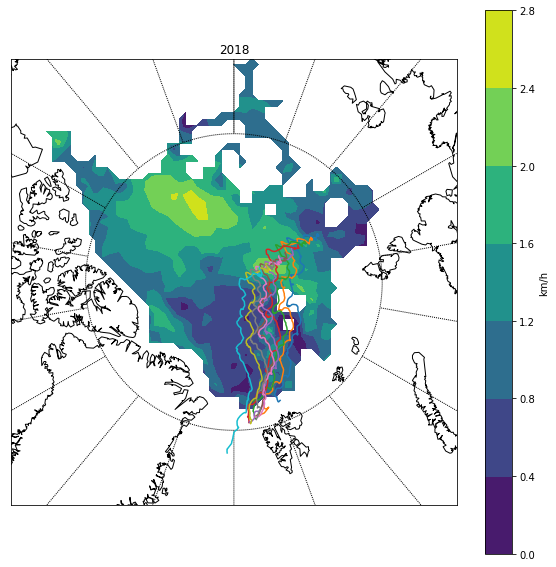

In [99]:
fig=plt.figure(figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
m.contourf(lon_map,lat_map,plotfield)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj)
    

cbar=plt.colorbar()
cbar.set_label('km/h')
plt.title('2018')
plt.show()

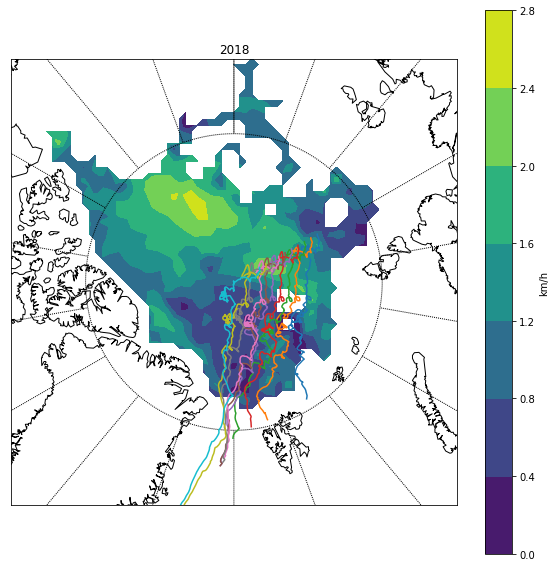

In [94]:
fig=plt.figure(figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
m.contourf(lon_map,lat_map,plotfield)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj)
    

cbar=plt.colorbar()
cbar.set_label('km/h')
plt.title('2018')
plt.show()

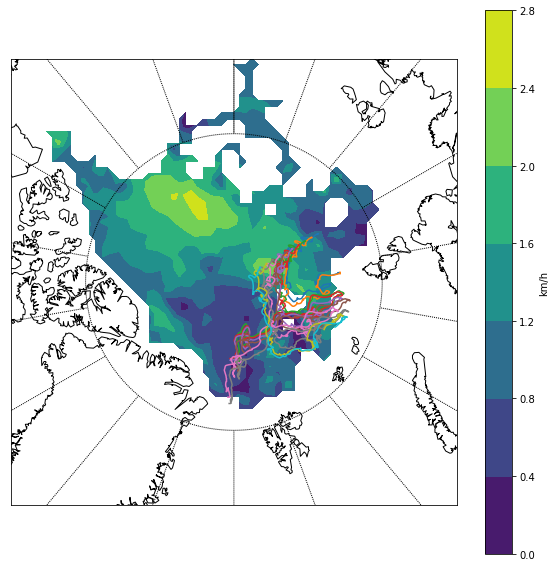

In [65]:
fig=plt.figure(figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
m.contourf(lon_map,lat_map,plotfield)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj)
    

cbar=plt.colorbar()
cbar.set_label('km/h')
plt.show()

### export to SIDFEx format 

##### example header:

In [85]:
#SubmitYear: 2019
#SubmitDayOfYear: 136.362
#ProcessedYear: 2019
#ProcessedDayOfYear: 136.375
#### end of auto header
#GroupID: awi001
#MethodID: ClimRunVers2019May
#TargetID: 300234066830700
#InitYear: 2019
#InitDayOfYear: 90
#InitLat: 73.63310
#InitLon: -8.17290
#EnsMemNum: 010
#### end of header
#Year DayOfYear Lat Lon
#2019  90  73.63310  -8.17290

##### fake a header for our trajectories

In [86]:
def export_to_SIDFEx(TargetIDs,GroupID='mss001', MethodID='ClimRunOSISAF',EnsMemNum=1):

    # CONTRIBUTION DETAILS
    GroupID=GroupID # MOSAiC Summer School
    MethodID=MethodID
    EnsMemNum=EnsMemNum

    for TargetID,TargetIDstring in enumerate(TargetIDs):

        print(lons_df[TargetID].index)
        print(np.isfinite(lons_df[TargetID].values))
        print(lons_df[TargetID].index[np.isfinite(lons_df[TargetID].values)][0])
        
        # initial time of the trajectory; ignore initial NaNs
        initialtime_traj=datetime.strptime(lons_df[TargetID].index[np.isfinite(lons_df[TargetID].values)][0], "%Y-%m-%d %H:%M:%S")
        InitYear=initialtime_traj.year

        # initial day of the trajectory (counted from beginning of the year)
        begin_initializedyear=str(InitYear)+'-01-01 00:00:00'
        # difference in fractional days
        delta=initialtime_traj - datetime.strptime(begin_initializedyear, "%Y-%m-%d %H:%M:%S")
        #fracdays=delta.total_seconds() / timedelta(days=1).total_seconds()
        InitDayOfYear=delta.days + 1 # IABP convention

        # intial position
        InitLat=np.round(lats_df[TargetID][np.isfinite(lats_df[TargetID].values)][0],5)
        InitLon=np.round(lons_df[TargetID][np.isfinite(lons_df[TargetID].values)][0],5)

        # SUBMISSION DETAILS
        # beginning of this year
        initialdate='2019-01-01 00:00:00'
        yearbegin = datetime.strptime(initialdate, "%Y-%m-%d %H:%M:%S")
        # current time
        now=datetime.now()
        # difference in fractional days
        delta=now - yearbegin
        fracdays=delta.total_seconds() / timedelta(days=1).total_seconds() + 1 # IABP convention

        # create the header of SIDFEx format
        SubmitYear=now.year
        SubmitDayOfYear=np.round(fracdays,3) #np.round(delta.days,3)
        ProcessedYear=now.year
        ProcessedDayOfYear=np.round(fracdays,3) #np.round(delta.days,3)

        # fake auto header (usually done on DKRZ cloud)
        autoheader= "SubmitYear: "+str(SubmitYear)+ \
            "\nSubmitDayOfYear: "+str(SubmitDayOfYear)+ \
            "\nProcessedYear: "+str(ProcessedYear)+ \
            "\nProcessedDayOfYear: "+str(ProcessedDayOfYear)+ \
            "\n### end of auto header"

        #print autoheader

        # main header
        mainheader= "\nGroupID: "+GroupID+ \
            "\nMethodID: "+MethodID+ \
            "\nTargetID: "+TargetIDstring+ \
            "\nInitYear: "+str(InitYear)+ \
            "\nInitDayOfYear: "+str(InitDayOfYear)+ \
            "\nInitLat: "+str(InitLat)+ \
            "\nInitLon: "+str(InitLon)+ \
            "\nEnsMemNum: "+str(EnsMemNum).zfill(3)+ \
            "\n### end of header"
        

        # Year DayOfYear Lat Lon
        # 2019  90  73.63310  -8.17290
        header=autoheader+mainheader+"\nYear DayOfYear Lat Lon"

        print(header)

        # main data here

        # initialize X
        length=lons_df[TargetID][np.isfinite(lons_df[TargetID].values)].shape[0]
        X=np.zeros((length,4))

        # fill with positions
        X[:,2]=np.round(lats_df[TargetID][np.isfinite(lats_df[TargetID].values)],5)
        X[:,3]=np.round(lons_df[TargetID][np.isfinite(lons_df[TargetID].values)],5)

        # fill X with date information
        for i,val in enumerate(lons_df[TargetID][np.isfinite(lons_df[TargetID].values)].index.tolist()):
    
            # fill X with year information
            date=datetime.strptime(val, "%Y-%m-%d %H:%M:%S")
            X[i,0]=date.year
    
            # fill X with day of year information
            begin_ofyear=str(date.year)+'-01-01 00:00:00'
            delta=date - datetime.strptime(begin_ofyear, "%Y-%m-%d %H:%M:%S")
            #fracdays=delta.total_seconds() / timedelta(days=1).total_seconds()
            X[i,1]=delta.days+1 # IABP convention
    
        print(X[0,:])

        # save the file
        np.savetxt(GroupID+'_'+MethodID+'_'+str(TargetIDstring)+'_'+str(InitYear)+'-'+str(InitDayOfYear)+'_'+str(EnsMemNum).zfill(3)+'.txt',X, header=header, fmt='%i  %i  %f  %f', comments='')

In [87]:
export_to_SIDFEx(TargetIDs=targets_ID[:,0],GroupID='mss001', MethodID='ClimRunOSISAF',EnsMemNum=1)

Index([u'2017-01-01 12:00:00', u'2017-01-02 12:00:00', u'2017-01-03 12:00:00',
       u'2017-01-04 12:00:00', u'2017-01-05 12:00:00', u'2017-01-06 12:00:00',
       u'2017-01-07 12:00:00', u'2017-01-08 12:00:00', u'2017-01-09 12:00:00',
       u'2017-01-10 12:00:00',
       ...
       u'2019-08-27 12:00:00', u'2019-08-28 12:00:00', u'2019-08-29 12:00:00',
       u'2019-08-30 12:00:00', u'2019-08-31 12:00:00', u'2019-09-01 12:00:00',
       u'2019-09-02 12:00:00', u'2019-09-03 12:00:00', u'2019-09-04 12:00:00',
       u'2019-09-05 12:00:00'],
      dtype='object', length=978)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  Tru

SubmitYear: 2019
SubmitDayOfYear: 262.486
ProcessedYear: 2019
ProcessedDayOfYear: 262.486
### end of auto header
GroupID: mss001
MethodID: ClimRunOSISAF
TargetID: 300234063803010
InitYear: 2017
InitDayOfYear: 170
InitLat: 69.0574
InitLon: 191.0346
EnsMemNum: 001
### end of header
Year DayOfYear Lat Lon
[2017.      170.       69.0574  191.0346]
Index([u'2017-01-01 12:00:00', u'2017-01-02 12:00:00', u'2017-01-03 12:00:00',
       u'2017-01-04 12:00:00', u'2017-01-05 12:00:00', u'2017-01-06 12:00:00',
       u'2017-01-07 12:00:00', u'2017-01-08 12:00:00', u'2017-01-09 12:00:00',
       u'2017-01-10 12:00:00',
       ...
       u'2019-08-27 12:00:00', u'2019-08-28 12:00:00', u'2019-08-29 12:00:00',
       u'2019-08-30 12:00:00', u'2019-08-31 12:00:00', u'2019-09-01 12:00:00',
       u'2019-09-02 12:00:00', u'2019-09-03 12:00:00', u'2019-09-04 12:00:00',
       u'2019-09-05 12:00:00'],
      dtype='object', length=978)
[ True  True  True  True  True  True  True  True  True  True  True  True

[2017.         3.        74.52214  167.18381]
Index([u'2017-01-01 12:00:00', u'2017-01-02 12:00:00', u'2017-01-03 12:00:00',
       u'2017-01-04 12:00:00', u'2017-01-05 12:00:00', u'2017-01-06 12:00:00',
       u'2017-01-07 12:00:00', u'2017-01-08 12:00:00', u'2017-01-09 12:00:00',
       u'2017-01-10 12:00:00',
       ...
       u'2019-08-27 12:00:00', u'2019-08-28 12:00:00', u'2019-08-29 12:00:00',
       u'2019-08-30 12:00:00', u'2019-08-31 12:00:00', u'2019-09-01 12:00:00',
       u'2019-09-02 12:00:00', u'2019-09-03 12:00:00', u'2019-09-04 12:00:00',
       u'2019-09-05 12:00:00'],
      dtype='object', length=978)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False 

2018-06-17 12:00:00
SubmitYear: 2019
SubmitDayOfYear: 262.486
ProcessedYear: 2019
ProcessedDayOfYear: 262.486
### end of auto header
GroupID: mss001
MethodID: ClimRunOSISAF
TargetID: 300234066031190
InitYear: 2018
InitDayOfYear: 168
InitLat: 84.10856
InitLon: 260.14691
EnsMemNum: 001
### end of header
Year DayOfYear Lat Lon
[2018.       168.        84.10856  260.14691]
Index([u'2017-01-01 12:00:00', u'2017-01-02 12:00:00', u'2017-01-03 12:00:00',
       u'2017-01-04 12:00:00', u'2017-01-05 12:00:00', u'2017-01-06 12:00:00',
       u'2017-01-07 12:00:00', u'2017-01-08 12:00:00', u'2017-01-09 12:00:00',
       u'2017-01-10 12:00:00',
       ...
       u'2019-08-27 12:00:00', u'2019-08-28 12:00:00', u'2019-08-29 12:00:00',
       u'2019-08-30 12:00:00', u'2019-08-31 12:00:00', u'2019-09-01 12:00:00',
       u'2019-09-02 12:00:00', u'2019-09-03 12:00:00', u'2019-09-04 12:00:00',
       u'2019-09-05 12:00:00'],
      dtype='object', length=978)
[False False False False False False False Fal

Year DayOfYear Lat Lon
[2019.       211.        83.99149  139.92696]
Index([u'2017-01-01 12:00:00', u'2017-01-02 12:00:00', u'2017-01-03 12:00:00',
       u'2017-01-04 12:00:00', u'2017-01-05 12:00:00', u'2017-01-06 12:00:00',
       u'2017-01-07 12:00:00', u'2017-01-08 12:00:00', u'2017-01-09 12:00:00',
       u'2017-01-10 12:00:00',
       ...
       u'2019-08-27 12:00:00', u'2019-08-28 12:00:00', u'2019-08-29 12:00:00',
       u'2019-08-30 12:00:00', u'2019-08-31 12:00:00', u'2019-09-01 12:00:00',
       u'2019-09-02 12:00:00', u'2019-09-03 12:00:00', u'2019-09-04 12:00:00',
       u'2019-09-05 12:00:00'],
      dtype='object', length=978)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa